In [1]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from data_tools.plotting import count_plot_h
from data_tools import combine_nodes_and_edges
from tools.hetnet_file_processing import read_reactome
from data_tools.df_processing import combine_group_cols_on_char

/home/mmayers/projects/metapaths/1_code/tools/processing.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
prev_dir = Path('../2_pipeline/02a_Reactome_DB_Queries/out/').resolve()
download_dir = Path('../2_pipeline/00_download_data/out/').resolve()

# Read in the Previous Query Results and Flat File Data

## Query Results

In [3]:
# Each result has differeing columns, so can't just concat them...
edge_res = dict()

for file in prev_dir.iterdir():
    # Get the name of the file
    name = file.name.replace('.csv', '')
    df = pd.read_csv(file)
    
    # Add CURIs Reactome IDs
    for c in df.columns:
        if 'rxn_id' in c or 'evt_id' in c or 'pe_id' in c or 'pw_id' in c or 'cplx_id' in c:
            df[c] = 'REACT' + ':' + df[c]
    
    edge_res[name] = df

In [4]:
next(iter(edge_res.values())).head()

,tax_id,tax_name,type,pe_id,pe_name
0,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-351080,Fz1:Dvl2:Daam1:RhoA:GTP [plasma membrane]
1,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-351023,Fz1:Dvl2:Daam1 [plasma membrane]
2,NCBITaxon:9606,Homo sapiens,species,REACT:R-HSA-194545,RhoA (Mg cofactor):GTP [plasma membrane]
3,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-206831,Wnt1:Frizzled1:phospho (3 sites) LRP6:CKIgamma...
4,NCBITaxon:9606,Homo sapiens,species,REACT:R-HSA-205884,"p-T1479,S1490,T1493-LRP6 [plasma membrane]"


## Flat Files

In [5]:
curi_map = {'miRBase': 'MI', 'Ensembl': 'ENSG', 'UniProt': 'UniProt', 'ChEBI': 'CHEBI', 'NCBI': 'NCBIGene'}

#### Reaction to Physical Entity (PE)

In [6]:
reactions = []
print('Reading...')
for file in download_dir.glob('*PE_Reactions*'):
    print(file.name)
    
    # Add reactome CURIS
    df = read_reactome(file)
    df['reactome_id'] = 'REACT' + ':' + df['reactome_id']
    df['pe_reactome_id'] = 'REACT' + ':' + df['pe_reactome_id']
    
    # Add PE ID source for easy filtering
    pe_source = file.name.split('2Reactome')[0]
    df['pe_source'] = pe_source

    # Add CURIs to PE External Identifiers
    curi = curi_map[pe_source]
    df['external_id'] = curi + ':' + df['external_id']

    reactions.append(df)
reactions = pd.concat(reactions, sort=False, ignore_index=True)
print('Done')

Reading...
miRBase2Reactome_PE_Reactions.txt
NCBI2Reactome_PE_Reactions.txt
UniProt2Reactome_PE_Reactions.txt
Ensembl2Reactome_PE_Reactions.txt
ChEBI2Reactome_PE_Reactions.txt
Done


In [7]:
reactions.drop_duplicates(subset=['pe_source'])

,external_id,pe_reactome_id,pe_name,reactome_id,reactome_url,reactome_name,evidence_code,taxon,pe_source
0,MI:MI0000071,REACT:R-HSA-8938437,miR-17 [cytosol],REACT:R-HSA-8935785,https://reactome.org/PathwayBrowser/#/R-HSA-89...,"RUNX1 mRNA translation is inhibited by miR-17,...",TAS,Homo sapiens,miRBase
170,NCBIGene:1,REACT:R-HSA-6806490,A1BG [extracellular region],REACT:R-HSA-481007,https://reactome.org/PathwayBrowser/#/R-HSA-48...,Exocytosis of platelet alpha granule contents,TAS,Homo sapiens,NCBI
747798,UniProt:A0A023GRW3,REACT:R-DME-72049,RBM5 [nucleoplasm],REACT:R-DME-156661,https://reactome.org/PathwayBrowser/#/R-DME-15...,Formation of Exon Junction Complex,IEA,Drosophila melanogaster,UniProt
1755175,ENSG:C34F11.9e,REACT:R-CEL-3772396,phospho-pp-DVL1 [cytosol],REACT:R-CEL-1504186,https://reactome.org/PathwayBrowser/#/R-CEL-15...,DVL recruits GSK3beta:AXIN1 to the receptor co...,IEA,Caenorhabditis elegans,Ensembl
2827467,CHEBI:10033,REACT:R-ALL-9014945,warfarin [cytosol],REACT:R-BTA-159790,https://reactome.org/PathwayBrowser/#/R-BTA-15...,VKORC1 reduces vitamin K epoxide to MK4 (vitam...,IEA,Bos taurus,ChEBI


#### Pathway to PE

In [8]:
pathways = []
print('Reading...')
for file in download_dir.glob('*PE_All*'):
    print(file.name)
    
    # Add reactome CURIS
    df = read_reactome(file)
    df['reactome_id'] = 'REACT' + ':' + df['reactome_id']
    df['pe_reactome_id'] = 'REACT' + ':' + df['pe_reactome_id']
    
    # Add PE ID source for easy filtering
    pe_source = file.name.split('2Reactome')[0]
    df['pe_source'] = pe_source

    # Add CURIs to PE External Identifiers
    curi = curi_map[pe_source]
    df['external_id'] = curi + ':' + df['external_id']

    pathways.append(df)
pathways = pd.concat(pathways, sort=False, ignore_index=True)
print('Done')

Reading...
miRBase2Reactome_PE_All_Levels.txt
Ensembl2Reactome_PE_All_Levels.txt
UniProt2Reactome_PE_All_Levels.txt
ChEBI2Reactome_PE_All_Levels.txt
NCBI2Reactome_PE_All_Levels.txt
Done


In [9]:
pathways.drop_duplicates(subset=['pe_source'])

,external_id,pe_reactome_id,pe_name,reactome_id,reactome_url,reactome_name,evidence_code,taxon,pe_source
0,MI:MI0000071,REACT:R-HSA-8938437,miR-17 [cytosol],REACT:R-HSA-1257604,https://reactome.org/PathwayBrowser/#/R-HSA-12...,PIP3 activates AKT signaling,TAS,Homo sapiens,miRBase
270,ENSG:C34F11.9e,REACT:R-CEL-3772396,phospho-pp-DVL1 [cytosol],REACT:R-CEL-162582,https://reactome.org/PathwayBrowser/#/R-CEL-16...,Signal Transduction,IEA,Caenorhabditis elegans,Ensembl
1623634,UniProt:A0A023GRW3,REACT:R-DME-72049,RBM5 [nucleoplasm],REACT:R-DME-72163,https://reactome.org/PathwayBrowser/#/R-DME-72163,mRNA Splicing - Major Pathway,IEA,Drosophila melanogaster,UniProt
3170520,CHEBI:10033,REACT:R-ALL-9014945,warfarin [cytosol],REACT:R-BTA-1430728,https://reactome.org/PathwayBrowser/#/R-BTA-14...,Metabolism,IEA,Bos taurus,ChEBI
3484209,NCBIGene:1,REACT:R-HSA-6806490,A1BG [extracellular region],REACT:R-HSA-109582,https://reactome.org/PathwayBrowser/#/R-HSA-10...,Hemostasis,TAS,Homo sapiens,NCBI


### Make a PE Reacome to External Map

In [10]:
map_cols = ['pe_reactome_id', 'external_id']
pe_to_external = pd.concat([reactions[map_cols], pathways[map_cols]], sort=False, ignore_index=True)
pe_to_external = pe_to_external.drop_duplicates()

In [11]:
len(pe_to_external), pe_to_external['pe_reactome_id'].nunique(), pe_to_external['external_id'].nunique()

(652124, 240940, 253985)

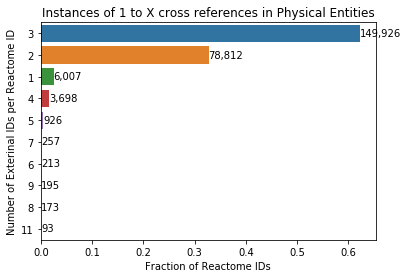

In [12]:
counts = pe_to_external.groupby('pe_reactome_id')['external_id'].nunique().value_counts().head(10)
fraction = (counts / pe_to_external['pe_reactome_id'].nunique())

count_plot_h(fraction, counts)
plt.title('Instances of 1 to X cross references in Physical Entities')
plt.xlabel('Fraction of Reactome IDs')
plt.ylabel('Number of Exterinal IDs per Reactome ID');

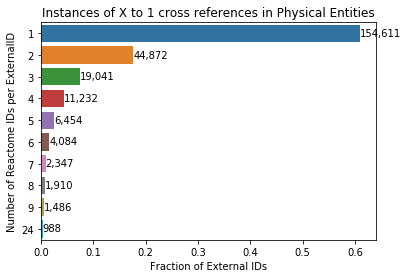

In [13]:
counts = pe_to_external.groupby('external_id')['pe_reactome_id'].nunique().value_counts().head(10)
fraction = (counts / pe_to_external['external_id'].nunique())

count_plot_h(fraction, counts)
plt.title('Instances of X to 1 cross references in Physical Entities')
plt.xlabel('Fraction of External IDs')
plt.ylabel('Number of Reactome IDs per ExternalID');

Likely several Many to Many relationships here...

### One final thought on PE names... 

Names for PEs in reacome are very messy... Reactome has both entity and location ontained in the identifier so Warfarin [extracellular] is different than Warfarin [cytoplasam] but both xref to the same ChEBI id.  Even if you remove the locaiton from the name by splitting out the brackets, sometimes you chan have many unique names for external Items.  

For these reasons, we will have to normalize names with an external resource.  We will save this for a later notebook and for now put in placesholder names.

In [14]:
pe_to_external.head(2)

,pe_reactome_id,external_id
0,REACT:R-HSA-8938437,MI:MI0000071
6,REACT:R-HSA-8935923,MI:MI0000072


In [15]:
map_cols = ['external_id', 'pe_name']
pe_to_name = pd.concat([reactions[map_cols], pathways[map_cols]], sort=False, ignore_index=True)
pe_to_name = pe_to_name.drop_duplicates(subset=['external_id', 'pe_name'])
pe_to_name.head(2)

,external_id,pe_name
0,MI:MI0000071,miR-17 [cytosol]
6,MI:MI0000072,miR-18a [cytosol]


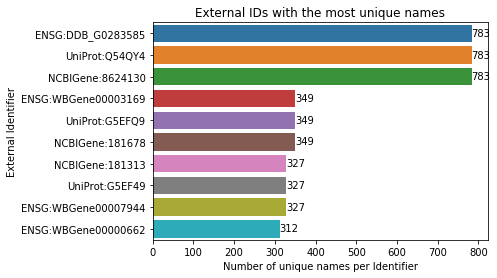

In [16]:
count_plot_h(pe_to_name['external_id'].value_counts().head(10))
plt.title('External IDs with the most unique names')
plt.xlabel('Number of unique names per Identifier')
plt.ylabel('External Identifier');

Even removing the location data from the name results in many identifiers with multiple names

In [17]:
print('{:,}'.format(len(pe_to_name)))
pe_to_name['pe_name'] = pe_to_name['pe_name'].apply(lambda n: n.split(' [')[0])
pe_to_name = pe_to_name.drop_duplicates()
print('{:,}'.format(len(pe_to_name)))

647,920
484,046


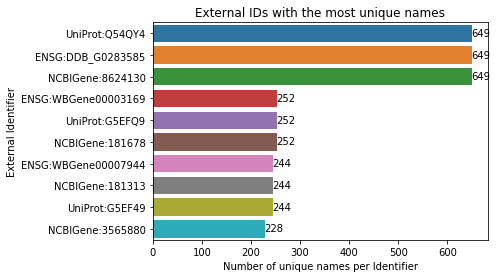

In [18]:
count_plot_h(pe_to_name['external_id'].value_counts().head(10))
plt.title('External IDs with the most unique names')
plt.xlabel('Number of unique names per Identifier')
plt.ylabel('External Identifier');

In [19]:
pe_to_name.query('external_id == "UniProt:Q54QY4"').sample(5, random_state=0)

,external_id,pe_name
1540618,UniProt:Q54QY4,3x4Hyp-GlcGalHyl-COL1A1(23-1464)
1539966,UniProt:Q54QY4,3x4Hyp-5Hyl-COL9A2
1539852,UniProt:Q54QY4,3x4Hyp-3Hyp-GalHyl-COL8A2
1540860,UniProt:Q54QY4,GlcGalHyl-COL2A1(26-1487)
1540231,UniProt:Q54QY4,Hydroxylysino-5-ketonorlysyl 4-Hyp 5-Hyl colla...


Well just take one name from this long list and have to map a correct name from a different authoritative source later.

In [20]:
pe_to_name = pe_to_name.drop_duplicates(subset=['external_id']).reset_index(drop=True)
pe_to_name = dict(zip(pe_to_name['external_id'], pe_to_name['pe_name']))

### Remaining Flat files

#### Protein Role in Reaction

In [21]:
prot_role = pd.read_csv(download_dir.joinpath('ProteinRoleReaction.txt'), sep='\t', names=['prot', 'role', 'rxn'])
prot_role.head(2)

,prot,role,rxn
0,A0A023GRW3,output,R-DME-156661
1,A0A023GRW3,input,R-DME-156661


Lets be 100% certain that the proteins are all UniProt IDs

In [22]:
import re

# regex provided by UniProt (Yay!!! So helpful!!) https://www.uniprot.org/help/accession_numbers
uniprot_re = re.compile("[OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2}")

def is_uniprot_id(_id):
    m = uniprot_re.match(_id)
    # Not UniProt if Either No match (False) or 
    # Match but start != 0 or end != end of ID (only matches a substring)
    return bool(m) and (m.start() == 0 and m.end() == len(_id))

# all IDs are Uniprot?
prot_role['prot'].apply(is_uniprot_id).sum() == len(prot_role)

True

Good to go, lets add the CURIs

In [23]:
prot_role['prot'] = 'UniProt:' + prot_role['prot']
prot_role['rxn'] = 'REACT:' + prot_role['rxn']
prot_role.head(2)

,prot,role,rxn
0,UniProt:A0A023GRW3,output,REACT:R-DME-156661
1,UniProt:A0A023GRW3,input,REACT:R-DME-156661


Finally, lets fix the semmaintcs a bit...

In [24]:
prot_role['role'].value_counts()

output                    510698
input                     498109
catalystActivity          222238
regulatedBy                25441
entityFunctionalStatus      2373
Name: role, dtype: int64

entityFunctionalStatus is for Failed Reactions, indicating the protein that has issues in the given reaction

In [25]:
sem_map = {'output': 'has_output', 'input': 'has_input', 'catalystActivity': 'has_catalystist',
           'regulatedBy': 'regulates', 'entityFunctionalStatus': 'fucntion_altered_in'}

prot_role['role'] = prot_role['role'].map(sem_map)

#### GO Annotations for Reactome Items

In [26]:
gaf_cols = ['db', 'db_object_id', 'db_object_symbol','qualifier', 'go_id', 'db_reference', 'evidence_code',
 'with_or_from', 'aspect', 'db_object_name', 'db_object_synonym', 'db_object_type', 'taxon', 'date', 'assigned_by',
 'annotation_extension', 'gene_product_form_id']

goa = pd.read_csv(download_dir.joinpath('gene_association.reactome.gz'), sep='\t', comment='!', names=gaf_cols)
goa.head(2)

,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id
0,UniProtKB,A0A075B6P5,KV228_HUMAN,NaN,GO:0005576,REACTOME:R-HSA-166753,TAS,NaN,C,NaN,NaN,protein,taxon:9606,20161111,Reactome,NaN,NaN
1,UniProtKB,A0A075B6P5,KV228_HUMAN,NaN,GO:0005576,REACTOME:R-HSA-166792,TAS,NaN,C,NaN,NaN,protein,taxon:9606,20161111,Reactome,NaN,NaN


In [27]:
goa['db_reference'] = goa['db_reference'].str.replace('REACTOME:', 'REACT:')

In [28]:
goa['db'].value_counts()

UniProtKB    107478
Name: db, dtype: int64

All uniport so CURI can be added

In [29]:
goa['db_object_id'] = 'UniProt:' + goa['db_object_id']

In [30]:
goa['aspect'].value_counts()

C    84439
P    20404
F     2635
Name: aspect, dtype: int64

In [31]:
goa['db_reference'].str.contains('REACT:').sum() / len(goa)

0.9955153612832394

Almost all have a Reactome reference, but a small amount will need to be removed

In [32]:
aspect_label_map = {'P': 'Biological Process', 'F': 'Molecular Function', 'C': 'Cellular Component'}
aspect_type_map = {'P': 'involved_in', 'F': 'enables', 'C': 'part_of'}

goa['label'] = goa['aspect'].map(aspect_label_map)
goa['type'] = goa['aspect'].map(aspect_type_map)

goa.head(2)

,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id,label,type
0,UniProtKB,UniProt:A0A075B6P5,KV228_HUMAN,NaN,GO:0005576,REACT:R-HSA-166753,TAS,NaN,C,NaN,NaN,protein,taxon:9606,20161111,Reactome,NaN,NaN,Cellular Component,part_of
1,UniProtKB,UniProt:A0A075B6P5,KV228_HUMAN,NaN,GO:0005576,REACT:R-HSA-166792,TAS,NaN,C,NaN,NaN,protein,taxon:9606,20161111,Reactome,NaN,NaN,Cellular Component,part_of


## Start processing the Nodes and Edges

Pathways, Reactions, Events and Complexes will be in Reactome ID space. Everything Else either already have an External Identifier (as extracted at query-time) or will be mapped to one via the Physical Entities flat files.

#### Convert the PEs to Nodes

In [33]:
curi_to_type = {'MI': 'Micro RNA', 'ENSG': 'Gene', 'UniProt': 'Protein', 'CHEBI': 'Compound', 
                'NCBIGene': 'Gene', 'REACT': 'Complex'}

In [34]:
pe_nodes = pe_to_external['external_id'].rename('id').drop_duplicates().to_frame().reset_index(drop=True)
pe_nodes['name'] = pe_nodes['id'].map(pe_to_name)
pe_nodes['label'] = pe_nodes['id'].apply(lambda s: curi_to_type[s.split(':')[0]])
pe_nodes.head()

,id,name,label
0,MI:MI0000071,miR-17,Micro RNA
1,MI:MI0000072,miR-18a,Micro RNA
2,MI:MI0000073,miR-19a,Micro RNA
3,MI:MI0000074,miR-19b1,Micro RNA
4,MI:MI0000075,miR-19b2,Micro RNA


#### Process all the Reactions and Pathways

In [35]:
def process_nodes(df, id_col, name_col, label=''):
    this_nodes = df[[id_col, name_col]].copy()
    this_nodes.columns = ['id', 'name']
    
    # Allow for a column with labels to be passed
    if label in df.columns:
        this_nodes['label'] = df[label]
    else:
        this_nodes['label'] = label
    return this_nodes.drop_duplicates().reset_index(drop=True)


def process_edges(df, start_col, end_col, e_type, extra_cols=None):
    this_edge = df[[start_col, end_col]].copy()
    this_edge.columns = ['start_id', 'end_id']
    if e_type in df.columns:
        this_edge['type'] = df[e_type]
    else:
        this_edge['type'] = e_type
    if extra_cols:
        this_edge[extra_cols] = df[extra_cols]
    return this_edge.drop_duplicates().reset_index(drop=True)


In [36]:
reactome_nodes = []

In [37]:
rx_nodes = process_nodes(reactions, 'reactome_id', 'reactome_name', 'Reaction')
rx_nodes.head(2)

,id,name,label
0,REACT:R-HSA-8935785,"RUNX1 mRNA translation is inhibited by miR-17,...",Reaction
1,REACT:R-HSA-8938440,miR-17 binds RUNX1 mRNA,Reaction


In [38]:
# Check for duplicated Ids
rx_nodes['id'].nunique() == len(rx_nodes)

True

All are unique, that's great

In [39]:
reactome_nodes.append(rx_nodes)

In [40]:
reactions.head(2)

,external_id,pe_reactome_id,pe_name,reactome_id,reactome_url,reactome_name,evidence_code,taxon,pe_source
0,MI:MI0000071,REACT:R-HSA-8938437,miR-17 [cytosol],REACT:R-HSA-8935785,https://reactome.org/PathwayBrowser/#/R-HSA-89...,"RUNX1 mRNA translation is inhibited by miR-17,...",TAS,Homo sapiens,miRBase
1,MI:MI0000071,REACT:R-HSA-8938437,miR-17 [cytosol],REACT:R-HSA-8938440,https://reactome.org/PathwayBrowser/#/R-HSA-89...,miR-17 binds RUNX1 mRNA,TAS,Homo sapiens,miRBase


In [41]:
rx_edges = process_edges(reactions, 'external_id', 'reactome_id', 'part_of', 'evidence_code')

In [42]:
dsrc_map = {'IEA': 'computed', 'TAS': 'curated'}
rx_edges['dsrc_type'] = rx_edges['evidence_code'].map(dsrc_map)
comp_idx = rx_edges.query('dsrc_type == "computed"').index
rx_edges.loc[comp_idx, 'comp_type'] = 'IEA'
rx_edges = rx_edges.drop('evidence_code', axis=1)

In [43]:
rx_edges.sample(5, random_state=1390)

,start_id,end_id,type,dsrc_type,comp_type
1878384,ENSG:YOL062C,REACT:R-SCE-8866277,part_of,computed,IEA
805884,UniProt:O00337,REACT:R-HSA-109530,part_of,curated,NaN
1813527,ENSG:FBgn0014391,REACT:R-DME-164840,part_of,computed,IEA
1889630,CHEBI:15377,REACT:R-DRE-1602446,part_of,computed,IEA
454597,NCBIGene:8345,REACT:R-HSA-5617867,part_of,computed,IEA


In [44]:
pw_nodes = process_nodes(pathways, 'reactome_id', 'reactome_name', 'Pathway')
pw_nodes.head(2)

,id,name,label
0,REACT:R-HSA-1257604,PIP3 activates AKT signaling,Pathway
1,REACT:R-HSA-162582,Signal Transduction,Pathway


In [45]:
pw_nodes['id'].nunique() == len(pw_nodes)

True

In [46]:
reactome_nodes.append(pw_nodes)

In [47]:
reactome_nodes = pd.concat(reactome_nodes, sort=False, ignore_index=True)

In [48]:
pw_edges = process_edges(pathways, 'external_id', 'reactome_id', 'part_of', 'evidence_code')

In [49]:
dsrc_map = {'IEA': 'computed', 'TAS': 'curated', 'EXP': 'curated'}

pw_edges['dsrc_type'] = pw_edges['evidence_code'].map(dsrc_map)
comp_idx = pw_edges.query('dsrc_type == "computed"').index
pw_edges.loc[comp_idx, 'comp_type'] = 'IEA'
pw_edges = pw_edges.drop('evidence_code', axis=1)

In [50]:
pw_edges.sample(5, random_state=125)

,start_id,end_id,type,dsrc_type,comp_type
2390425,NCBIGene:493339,REACT:R-XTR-9007101,part_of,computed,IEA
927623,UniProt:A0A1L1RMR1,REACT:R-GGA-1280218,part_of,computed,IEA
2023787,NCBIGene:100855815,REACT:R-CFA-68886,part_of,computed,IEA
357773,ENSG:ENSG00000179218,REACT:R-HSA-5653656,part_of,computed,IEA
506903,ENSG:ENSMUSG00000034165,REACT:R-MMU-74160,part_of,computed,IEA


In [51]:
reactome_edges = pd.concat([rx_edges, pw_edges], sort=False, ignore_index=True)

In [52]:
reactome_evt_ids = reactome_nodes['id'].tolist()

def all_ids_in_react_nodes(df, ids_col):
    """Ensures all IDs in a column are in found in teh reactome IDs"""
    global reactome_evt_ids
    qstr = '{} not in @reactome_evt_ids'.format(ids_col)
    return len(df.query(qstr)) == 0

#### Add Protein Role Edges

In [53]:
# Process the proteins with a dummy name
role_nodes = process_nodes(prot_role, 'prot', 'role', 'Protein')
role_nodes['name'] = ''

In [54]:
role_edges = []
# Rxn to Protein {'has_input', 'has_output', 'has_catalyist'}
role_edges.append(process_edges(prot_role.query('role in {}'.format(['has_input', 'has_output', 'has_catalyist'])), 
                                'rxn', 'prot', 'role'))

role_edges[-1].head(2)

,start_id,end_id,type
0,REACT:R-DME-156661,UniProt:A0A023GRW3,has_output
1,REACT:R-DME-156661,UniProt:A0A023GRW3,has_input


In [55]:
# Protein to rxn {'regulates', 'fucntion_altered_in'}
role_edges.append(process_edges(prot_role.query('role in {}'.format(['regulates', 'fucntion_altered_in'])), 
                                'prot', 'rxn', 'role'))

role_edges[-1].head(2)

,start_id,end_id,type
0,UniProt:A0A061ADQ6,REACT:R-CEL-5672973,regulates
1,UniProt:A0A061ADQ6,REACT:R-CEL-5672978,regulates


In [56]:
role_edges = pd.concat(role_edges, sort=False, ignore_index=True)
role_edges['dsrc_type'] = 'curated'

#### Add GO Annotations

In [57]:
goa.head(2)

,db,db_object_id,db_object_symbol,qualifier,go_id,db_reference,evidence_code,with_or_from,aspect,db_object_name,db_object_synonym,db_object_type,taxon,date,assigned_by,annotation_extension,gene_product_form_id,label,type
0,UniProtKB,UniProt:A0A075B6P5,KV228_HUMAN,NaN,GO:0005576,REACT:R-HSA-166753,TAS,NaN,C,NaN,NaN,protein,taxon:9606,20161111,Reactome,NaN,NaN,Cellular Component,part_of
1,UniProtKB,UniProt:A0A075B6P5,KV228_HUMAN,NaN,GO:0005576,REACT:R-HSA-166792,TAS,NaN,C,NaN,NaN,protein,taxon:9606,20161111,Reactome,NaN,NaN,Cellular Component,part_of


In [58]:
# Ensure GO ids are included, with Dummy names
goa_nodes = []
go_nodes = process_nodes(goa, 'go_id', 'aspect', 'label')
go_nodes['name'] = ''
goa_nodes.append(go_nodes)
goa_nodes[-1].head(2)

,id,name,label
0,GO:0005576,,Cellular Component
1,GO:0005886,,Cellular Component


In [59]:
goa_nodes.append(process_nodes(goa, 'db_object_id', 'db_object_symbol', 'Protein'))
goa_nodes[-1].head(2)

,id,name,label
0,UniProt:A0A075B6P5,KV228_HUMAN,Protein
1,UniProt:A0A075B6S6,KVD30_HUMAN,Protein


When we combine nodes later, we will put these nodes last so proper those that have proper names will be chosen ahead of these with dummy empty names

In [60]:
goa_nodes = pd.concat(goa_nodes, sort=False, ignore_index=True)

In [61]:
goa_edges = []

goa_edges.append(process_edges(goa, 'db_object_id', 'go_id', 'type', extra_cols='evidence_code'))
goa_edges.append(process_edges(goa[goa['db_reference'].str.startswith('REACT:')],
                               'db_reference', 'go_id', 'type', extra_cols='evidence_code'))
goa_edges = pd.concat(goa_edges, sort=False, ignore_index=True)

In [62]:
goa_edges['dsrc_type'] = goa_edges['evidence_code'].map(dsrc_map)
comp_idx = goa_edges.query('dsrc_type == "computed"').index
goa_edges.loc[comp_idx, 'comp_type'] = 'IEA'
goa_edges = goa_edges.drop('evidence_code', axis=1)

In [63]:
goa_edges.sample(5, random_state=1389)

,start_id,end_id,type,dsrc_type,comp_type
43654,REACT:R-HSA-1433514,GO:0005829,part_of,curated,NaN
6591,UniProt:P06315,GO:0050776,involved_in,curated,NaN
32758,UniProt:Q9NQC8,GO:0005929,part_of,curated,NaN
11103,UniProt:P23219,GO:0005789,part_of,curated,NaN
763,UniProt:O00468,GO:0005576,part_of,curated,NaN


## Process Nodes and Edges from the Query Results

In [64]:
nodes = []
edges = []

In [65]:
edge_names = sorted(edge_res.keys())
it_n = iter(edge_names)

In [66]:
edge_name = next(it_n)
print(edge_name)

cplx_pe


In [67]:
edge_name = 'cplx_pe'

In [68]:
df = edge_res[edge_name]
df.head(2)

,cplx_id,cplx_name,pe_id,pe_name,pe_label
0,REACT:R-GGA-9652349,ERBB2 heterodimer:trastuzumab [plasma membrane],REACT:R-ALL-9634466,trastuzumab [extracellular region],"['DatabaseObject', 'PhysicalEntity', 'ProteinD..."
1,REACT:R-BTA-9652349,ERBB2 heterodimer:trastuzumab [plasma membrane],REACT:R-ALL-9634466,trastuzumab [extracellular region],"['DatabaseObject', 'PhysicalEntity', 'ProteinD..."


In [69]:
df = df.merge(pe_to_external, left_on='pe_id', right_on='pe_reactome_id', how='inner')
df.head(2)

,cplx_id,cplx_name,pe_id,pe_name,pe_label,pe_reactome_id,external_id
0,REACT:R-SSC-9011531,DCA:PDK2 [mitochondrial matrix],REACT:R-ALL-9010792,DCA [mitochondrial matrix],"['DatabaseObject', 'PhysicalEntity', 'Drug', '...",REACT:R-ALL-9010792,CHEBI:28240
1,REACT:R-CEL-9011531,DCA:PDK2 [mitochondrial matrix],REACT:R-ALL-9010792,DCA [mitochondrial matrix],"['DatabaseObject', 'PhysicalEntity', 'Drug', '...",REACT:R-ALL-9010792,CHEBI:28240


In [70]:
nodes.append(pe_nodes)

In [71]:
df['cplx_name'] = df['cplx_name'].apply(lambda s: s.split(' [')[0])
cplx_nodes = process_nodes(df, 'cplx_id', 'cplx_name', 'Complex')

In [72]:
nodes.append(cplx_nodes)

In [73]:
cplx_edges = process_edges(df, 'external_id', 'cplx_id', 'part_of')
cplx_edges['dsrc_type'] = 'curated'
cplx_edges.head()

,start_id,end_id,type,dsrc_type
0,CHEBI:28240,REACT:R-SSC-9011531,part_of,curated
1,CHEBI:28240,REACT:R-CEL-9011531,part_of,curated
2,CHEBI:28240,REACT:R-DRE-9011531,part_of,curated
3,CHEBI:28240,REACT:R-SPO-9011531,part_of,curated
4,CHEBI:28240,REACT:R-BTA-9011531,part_of,curated


In [74]:
edges.append(cplx_edges)

In [75]:
all_pe_ids = set(pe_to_external['pe_reactome_id']) | set(cplx_nodes['id'])

def prep_pe(df, pe_col):
    
    # Filter out things we don't care about [e.g. DefinedSet]
    df = df.query('{} in @all_pe_ids'.format(pe_col))
    
    # Make sure the columnname for merging is unique so we don't have to worrie about suffixes
    if pe_col in pe_to_external.columns:
        pe_col += '_input'
    
    mrg = df.merge(pe_to_external, left_on=pe_col, right_on='pe_reactome_id', how='left')
    mrg['external_id'] = mrg['external_id'].fillna(mrg[pe_col])
    return mrg
    

### Query 2

In [76]:
edge_name = next(it_n)
print(edge_name)

evt_bp


In [77]:
df = edge_res[edge_name]
df.head()

,evt_id,evt_name,type,curi,go_id,go_name
0,REACT:R-DME-9613354,Lipophagy,goBiologicalProcess,GO,GO:0061724,lipophagy
1,REACT:R-XTR-9613354,Lipophagy,goBiologicalProcess,GO,GO:0061724,lipophagy
2,REACT:R-DRE-9613354,Lipophagy,goBiologicalProcess,GO,GO:0061724,lipophagy
3,REACT:R-SSC-9613354,Lipophagy,goBiologicalProcess,GO,GO:0061724,lipophagy
4,REACT:R-BTA-9613354,Lipophagy,goBiologicalProcess,GO,GO:0061724,lipophagy


In [78]:
go_nodes = process_nodes(df, 'go_id', 'go_name', 'Biological Process')
go_nodes.head()

,id,name,label
0,GO:0061724,lipophagy,Biological Process
1,GO:0061684,chaperone-mediated autophagy,Biological Process
2,GO:0016236,macroautophagy,Biological Process
3,GO:0000423,mitophagy,Biological Process
4,GO:0097352,autophagosome maturation,Biological Process


In [79]:
go_nodes['id'].nunique() == len(go_nodes)

True

In [80]:
all_ids_in_react_nodes(df, 'evt_id')

True

In [81]:
nodes.append(go_nodes)

#### Now for the edges

In [82]:
this_edge = process_edges(df, 'evt_id', 'go_id', 'involved_in')
this_edge['dsrc_type'] = 'curated'
this_edge.head(2)

,start_id,end_id,type,dsrc_type
0,REACT:R-DME-9613354,GO:0061724,involved_in,curated
1,REACT:R-XTR-9613354,GO:0061724,involved_in,curated


In [83]:
edges.append(this_edge)

### Next Query

In [84]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

evt_cc


,evt_id,evt_name,type,curi,go_id,go_name
0,REACT:R-SCE-5333658,"CLAT:AP1:CLVS bind PI(3,5)P2",compartment,GO,GO:0005765,lysosomal membrane
1,REACT:R-SPO-5333658,"CLAT:AP1:CLVS bind PI(3,5)P2",compartment,GO,GO:0005765,lysosomal membrane


In [85]:
nodes.append(process_nodes(df, 'go_id', 'go_name', 'Cellular Component'))

In [86]:
all_ids_in_react_nodes(df, 'evt_id')

False

In [87]:
df.query('evt_id not in @reactome_evt_ids')

,evt_id,evt_name,type,curi,go_id,go_name
7924,REACT:R-MMU-446503,Opening of Low Conductance Potassium Channels,compartment,GO,GO:0005886,plasma membrane
30082,REACT:R-HSA-2130627,MHC class II antigen internalization,compartment,GO,GO:0005576,extracellular region
45395,REACT:R-ECO-159887,Translocation of ribosome by 3 bases in the 3'...,compartment,GO,GO:0005829,cytosol
65576,REACT:R-HSA-1236972,Escape of antigens from phagosome to cytosol,compartment,GO,GO:0005829,cytosol
85789,REACT:R-HSA-2130627,MHC class II antigen internalization,compartment,GO,GO:0043202,lysosomal lumen
92485,REACT:R-HSA-1236963,Maturation of phagosome into phagolysosome,compartment,GO,GO:0045335,phagocytic vesicle
96793,REACT:R-HSA-77612,Formation of dsRNA structure by looping,compartment,GO,GO:0005654,nucleoplasm
100528,REACT:R-HSA-5652137,Damaged dsDNA becomes damaged DNA template,compartment,GO,GO:0005654,nucleoplasm
101789,REACT:R-HSA-192781,"Viral mRNA Splicing (M, NS segments)",compartment,GO,GO:0005654,nucleoplasm
106745,REACT:R-HSA-77607,Formation of stem-loop structure in ApoB mRNA,compartment,GO,GO:0005654,nucleoplasm


These are all reactions

In [88]:
this_nodes = process_nodes(df.query('evt_id not in @reactome_evt_ids'), 'evt_id', 'evt_name', 'Reaction')
reactome_nodes = pd.concat([reactome_nodes, this_nodes], sort=False, ignore_index=True)
reactome_evt_ids = reactome_nodes['id'].tolist()

In [89]:
this_edge = process_edges(df, 'evt_id', 'go_id', 'part_of')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)
this_edge.head()

,start_id,end_id,type,dsrc_type
0,REACT:R-SCE-5333658,GO:0005765,part_of,curated
1,REACT:R-SPO-5333658,GO:0005765,part_of,curated
2,REACT:R-DDI-5333658,GO:0005765,part_of,curated
3,REACT:R-CEL-5333658,GO:0005765,part_of,curated
4,REACT:R-DME-5333658,GO:0005765,part_of,curated


### Next Query

In [90]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

evt_tax


,tax_id,tax_name,type,evt_id,evt_name
0,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-350375,Dvl2 binds to Daam1
1,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-350485,RhoA:GTP binds to activated Daam1


In [91]:
nodes.append(process_nodes(df, 'tax_id', 'tax_name', 'Taxon'))

In [92]:
all_ids_in_react_nodes(df, 'evt_id')

True

In [93]:
edges.append(process_edges(df, 'evt_id', 'tax_id', 'in_taxon'))

### Next Query

In [94]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

pe_cc


,pe_id,pe_name,type,curi,go_id,go_name
0,REACT:R-ALL-5334668,"PI(3,5)P2 [lysosomal membrane]",compartment,GO,GO:0005765,lysosomal membrane
1,REACT:R-XTR-429825,BLOC-1 Complex [lysosomal membrane],compartment,GO,GO:0005765,lysosomal membrane


In [95]:
this_df = prep_pe(df, 'pe_id')

In [96]:
this_df.head(2)

,pe_id,pe_name,type,curi,go_id,go_name,pe_reactome_id,external_id
0,REACT:R-ALL-5334668,"PI(3,5)P2 [lysosomal membrane]",compartment,GO,GO:0005765,lysosomal membrane,REACT:R-ALL-5334668,CHEBI:16851
1,REACT:R-XTR-429825,BLOC-1 Complex [lysosomal membrane],compartment,GO,GO:0005765,lysosomal membrane,NaN,REACT:R-XTR-429825


In [97]:
nodes.append(process_nodes(this_df, 'go_id', 'go_name', 'Cellular Component'))

In [98]:
this_edge = process_edges(this_df, 'external_id', 'go_id', 'part_of')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)

### Next Query

In [99]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

pe_tax


,tax_id,tax_name,type,pe_id,pe_name
0,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-351080,Fz1:Dvl2:Daam1:RhoA:GTP [plasma membrane]
1,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-351023,Fz1:Dvl2:Daam1 [plasma membrane]


In [100]:
pe = prep_pe(df, 'pe_id')
pe.head(2)

,tax_id,tax_name,type,pe_id,pe_name,pe_reactome_id,external_id
0,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-351080,Fz1:Dvl2:Daam1:RhoA:GTP [plasma membrane],NaN,REACT:R-NUL-351080
1,NCBITaxon:9606,Homo sapiens,species,REACT:R-NUL-351023,Fz1:Dvl2:Daam1 [plasma membrane],NaN,REACT:R-NUL-351023


In [101]:
nodes.append(process_nodes(pe, 'tax_id', 'tax_name', 'Taxon'))
nodes[-1].head(5)

,id,name,label
0,NCBITaxon:9606,Homo sapiens,Taxon
1,NCBITaxon:10116,Rattus norvegicus,Taxon
2,NCBITaxon:9615,Canis familiaris,Taxon
3,NCBITaxon:4896,Schizosaccharomyces pombe,Taxon
4,NCBITaxon:4932,Saccharomyces cerevisiae,Taxon


In [102]:
this_edge = process_edges(pe, 'external_id', 'tax_id', 'in_taxon')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)

### Next Query

In [103]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

pw_aw_dis


,pw_id,pw_name,type,curi,do_id,do_name
0,REACT:R-HSA-9605308,Diseases of Base Excision Repair,associated_with,DOID,DOID:162,cancer
1,REACT:R-HSA-9616333,Defective Base Excision Repair Associated with...,associated_with,DOID,DOID:162,cancer


In [104]:
nodes.append(process_nodes(df, 'do_id', 'do_name', 'Disease'))
nodes[-1].head()

,id,name,label
0,DOID:162,cancer,Disease
1,DOID:1612,breast cancer,Disease
2,DOID:3247,rhabdomyosarcoma,Disease
3,DOID:10652,Alzheimer's disease,Disease
4,DOID:1686,glaucoma,Disease


In [105]:
all_ids_in_react_nodes(df, 'pw_id')

True

In [106]:
this_edge = process_edges(df, 'pw_id', 'do_id', 'type')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)
edges[-1].head()

,start_id,end_id,type,dsrc_type
0,REACT:R-HSA-9605308,DOID:162,associated_with,curated
1,REACT:R-HSA-9616333,DOID:162,associated_with,curated
2,REACT:R-HSA-9630221,DOID:162,associated_with,curated
3,REACT:R-HSA-9630222,DOID:162,associated_with,curated
4,REACT:R-HSA-9616334,DOID:162,associated_with,curated


### Next Query

In [107]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

pw_di_dis


,pw_id,pw_name,type,dpw_id,dpw_name,type2,curi,do_id,do_name
0,REACT:R-HSA-73929,"Base-Excision Repair, AP Site Formation",disrupted_in,REACT:R-HSA-9630221,Defective NTHL1 substrate processing,disease,DOID,DOID:162,cancer
1,REACT:R-HSA-73929,"Base-Excision Repair, AP Site Formation",disrupted_in,REACT:R-HSA-9630222,Defective NTHL1 substrate binding,disease,DOID,DOID:162,cancer


In [108]:
nodes.append(process_nodes(df, 'do_id', 'do_name', 'Disease'))
nodes[-1].head()

,id,name,label
0,DOID:162,cancer,Disease
1,DOID:1612,breast cancer,Disease
2,DOID:3247,rhabdomyosarcoma,Disease
3,DOID:1686,glaucoma,Disease
4,DOID:9256,colorectal cancer,Disease


In [109]:
all_ids_in_react_nodes(df, 'pw_id')

True

In [110]:
this_edge = process_edges(df, 'pw_id', 'do_id', 'type')
this_edge['dsrc_type'] = 'computed'
this_edge['comp_type'] = 'punning'
edges.append(this_edge)
edges[-1].head()

,start_id,end_id,type,dsrc_type,comp_type
0,REACT:R-HSA-73929,DOID:162,disrupted_in,computed,punning
1,REACT:R-HSA-5358508,DOID:162,disrupted_in,computed,punning
2,REACT:R-HSA-2559585,DOID:162,disrupted_in,computed,punning
3,REACT:R-HSA-2559580,DOID:162,disrupted_in,computed,punning
4,REACT:R-HSA-109606,DOID:162,disrupted_in,computed,punning


### Next Query

In [111]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

pw_dpw


,dpw_id,dpw_name,type,pw_id,pw_name
0,REACT:R-HSA-6802957,Oncogenic MAPK signaling,normalPathway,REACT:R-HSA-5673001,RAF/MAP kinase cascade
1,REACT:R-HSA-6802949,Signaling by RAS mutants,normalPathway,REACT:R-HSA-5673001,RAF/MAP kinase cascade


In [112]:
all_ids_in_react_nodes(df, 'pw_id')

True

In [113]:
all_ids_in_react_nodes(df, 'dpw_id')

True

In [114]:
this_edge = process_edges(df, 'dpw_id', 'pw_id', 'disrupts')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)
edges[-1].head()

,start_id,end_id,type,dsrc_type
0,REACT:R-HSA-6802957,REACT:R-HSA-5673001,disrupts,curated
1,REACT:R-HSA-6802949,REACT:R-HSA-5673001,disrupts,curated
2,REACT:R-HSA-9649913,REACT:R-HSA-5673001,disrupts,curated
3,REACT:R-HSA-9649948,REACT:R-HSA-5673001,disrupts,curated
4,REACT:R-HSA-6802948,REACT:R-HSA-5673001,disrupts,curated


### Next Query

In [115]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

pw_rxn


,pw_id,pw_name,type,rxn_id,rxn_name
0,REACT:R-HSA-9613829,Chaperone Mediated Autophagy,hasEvent,REACT:R-HSA-9626253,HSPA8 binds LAMP2a multimers
1,REACT:R-HSA-9613829,Chaperone Mediated Autophagy,hasEvent,REACT:R-HSA-9625197,GFAP binds LAMP2a multimer


In [116]:
all_ids_in_react_nodes(df, 'pw_id') & all_ids_in_react_nodes(df, 'rxn_id')

True

In [117]:
edges.append(process_edges(df, 'rxn_id', 'pw_id', 'part_of'))
edges[-1].head()

,start_id,end_id,type
0,REACT:R-HSA-9626253,REACT:R-HSA-9613829,part_of
1,REACT:R-HSA-9625197,REACT:R-HSA-9613829,part_of
2,REACT:R-HSA-9626060,REACT:R-HSA-9613829,part_of
3,REACT:R-HSA-9625196,REACT:R-HSA-9613829,part_of
4,REACT:R-HSA-9622831,REACT:R-HSA-9613829,part_of


### Next Query

In [118]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

reg_edge


,pe_id,pe_name,pe_label,type,evt_id,evt_name,evt_label
0,REACT:R-HSA-917723,ESCRT-III [cytosol],PhysicalEntity,PositiveRegulation,REACT:R-HSA-5682388,Autophagosome maturation,Event
1,REACT:R-HSA-5683632,UVRAG complex [cytosol],PhysicalEntity,PositiveRegulation,REACT:R-HSA-5682388,Autophagosome maturation,Event


In [119]:
prepped = prep_pe(df, 'pe_id')

In [120]:
all_ids_in_react_nodes(prepped, 'evt_id')

True

In [121]:
reg_edges = process_edges(prepped, 'external_id', 'evt_id', 'type')

In [122]:
reg_map = {'PositiveRegulation': 'positively_regulates', 'NegativeRegulation': 'negatively_regulates'}
reg_edges['type'] = reg_edges['type'].map(reg_map)
reg_edges['dsrc_type'] = 'curated'

In [123]:
edges.append(reg_edges)
reg_edges.head()

,start_id,end_id,type,dsrc_type
0,REACT:R-HSA-917723,REACT:R-HSA-5682388,positively_regulates,curated
1,REACT:R-HSA-5683632,REACT:R-HSA-5682388,positively_regulates,curated
2,REACT:R-MMU-5683632,REACT:R-MMU-5682388,positively_regulates,curated
3,REACT:R-MMU-917723,REACT:R-MMU-5682388,positively_regulates,curated
4,REACT:R-RNO-5683632,REACT:R-RNO-5682388,positively_regulates,curated


### Next Query

In [124]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

rxn_aw_dis


,rxn_id,rxn_name,type,curi,do_id,do_name
0,REACT:R-HSA-2400009,PI3K inhibitors block PI3K catalytic activity,associated_with,DOID,DOID:162,cancer
1,REACT:R-HSA-2394007,PI3K gain of function mutants phosphorylate PI...,associated_with,DOID,DOID:162,cancer


In [125]:
all_ids_in_react_nodes(df, 'rxn_id')

True

In [126]:
nodes.append(process_nodes(df, 'do_id', 'do_name', 'Disease'))

In [127]:
this_edge = process_edges(df, 'rxn_id', 'do_id', 'type')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)

### Next Query

In [128]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

rxn_di_dis


,rxn_id,rxn_name,type,drxn_id,drxn_name,type2,curi,do_id,do_name
0,REACT:R-HSA-5658435,RAS GAPs bind RAS:GTP,disrupted_in,REACT:RAS GAP mutants aren't stimulated by GAPs,R-HSA-9651280,disease,DOID,DOID:0060233,cardiofaciocutaneous syndrome
1,REACT:R-HSA-5658435,RAS GAPs bind RAS:GTP,disrupted_in,REACT:RAS GAP mutants aren't stimulated by GAPs,R-HSA-9651280,disease,DOID,DOID:162,cancer


In [129]:
all_ids_in_react_nodes(df, 'rxn_id')

True

In [130]:
nodes.append(process_nodes(df, 'do_id', 'do_name', 'Disease'))

In [131]:
this_edge = process_edges(df, 'rxn_id', 'do_id', 'type')
this_edge['dsrc_type'] = 'computed'
this_edge['comp_type'] = 'punning'
edges.append(this_edge)

### Next Query

In [132]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

rxn_frxn


,frxn_id,frxn_name,type,rxn_id,rxn_name
0,REACT:R-HSA-9651280,RAS GAP mutants aren't stimulated by GAPs,normalReaction,REACT:R-HSA-5658435,RAS GAPs bind RAS:GTP
1,REACT:R-HSA-6802837,Loss-of-function NF1 variants don't stimulate ...,normalReaction,REACT:R-HSA-5658435,RAS GAPs bind RAS:GTP


In [133]:
all_ids_in_react_nodes(df, 'rxn_id') & all_ids_in_react_nodes(df, 'frxn_id')

True

In [134]:
this_edge = process_edges(df, 'frxn_id', 'rxn_id', 'disrupts')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)

### Next Query

In [135]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

rxn_p_rxn


,af_rxn_id,af_rxn_name,type,b4_rxn_id,b4_rxn_name
0,REACT:R-HSA-9626034,EEF1A1 dissociates from p-GFAP,precedingEvent,REACT:R-HSA-9626046,p-GFAP binds EEF1A1
1,REACT:R-MMU-9626034,EEF1A1 dissociates from p-GFAP,precedingEvent,REACT:R-MMU-9626046,p-GFAP binds EEF1A1


In [136]:
all_ids_in_react_nodes(df, 'af_rxn_id') & all_ids_in_react_nodes(df, 'b4_rxn_id')

True

In [137]:
this_edge = process_edges(df, 'af_rxn_id', 'b4_rxn_id', 'follows_in_sequence')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)

### Next Query

In [138]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

rxn_pe


,rxn_id,rxn_name,type,pe_id,pe_name
0,REACT:R-HSA-9626034,EEF1A1 dissociates from p-GFAP,output,REACT:R-HSA-9626022,EEF1A1 [lysosomal membrane]
1,REACT:R-HSA-9626034,EEF1A1 dissociates from p-GFAP,output,REACT:R-HSA-9626054,p-GFAP [lysosomal membrane]


In [139]:
all_ids_in_react_nodes(df, 'rxn_id')

True

In [140]:
prepped = prep_pe(df, 'pe_id')

In [141]:
prepped.head(2)

,rxn_id,rxn_name,type,pe_id,pe_name,pe_reactome_id,external_id
0,REACT:R-HSA-9626034,EEF1A1 dissociates from p-GFAP,output,REACT:R-HSA-9626022,EEF1A1 [lysosomal membrane],REACT:R-HSA-9626022,NCBIGene:1915
1,REACT:R-HSA-9626034,EEF1A1 dissociates from p-GFAP,output,REACT:R-HSA-9626022,EEF1A1 [lysosomal membrane],REACT:R-HSA-9626022,UniProt:P68104


In [142]:
prepped['type'] = 'has_' + prepped['type']
prepped['type'].value_counts()

has_input                     170777
has_output                    125652
has_entityOnOtherCell            332
has_requiredInputComponent        47
Name: type, dtype: int64

has_entityOnOtherCell and has_requiredInputComponent are two low-population edges that don't add much. Will drop

In [143]:
drop_idx = prepped.query('type == "has_entityOnOtherCell" or type == "has_requiredInputComponent"').index
prepped = prepped.drop(drop_idx)

In [144]:
this_edge = process_edges(prepped, 'rxn_id', 'external_id', 'type')
this_edge['dsrc_type'] = 'curated'
edges.append(this_edge)
edges[-1].head(2)

,start_id,end_id,type,dsrc_type
0,REACT:R-HSA-9626034,NCBIGene:1915,has_output,curated
1,REACT:R-HSA-9626034,UniProt:P68104,has_output,curated


### Next Query

In [145]:
edge_name = next(it_n)
print(edge_name)
df = edge_res[edge_name]
df.head(2)

tax_dis


,tax_id,tax_name,curi,do_id,do_name
0,NCBITaxon:10090,Mus musculus,DOID,DOID:162,cancer
1,NCBITaxon:28875,Rotavirus A,DOID,DOID:934,viral infectious disease


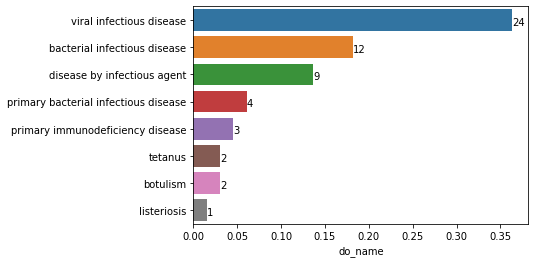

In [146]:
count_plot_h(df['do_name'].value_counts().head(8) / len(df), df['do_name'].value_counts().head(8))

I'm not impressed by the results of this edge... with only 60 odd results, and many of them being problematic due to lack of specificity; Like viral infectious disease, bacterial infectious disease, or disease by infectious agent. The majoity of these are not useful

# Filter the results

In [147]:
nodes = pd.concat([reactome_nodes]+nodes+[goa_nodes, role_nodes], ignore_index=True, sort=False)
print('{:,}'.format(len(nodes)))
nodes = nodes.drop_duplicates(subset=['id'], keep='first')
print('{:,}'.format(len(nodes)))

644,818
426,779


#### Keep Reactome PE Xrefs for now

In [148]:
pe_to_external.head(2)

,pe_reactome_id,external_id
0,REACT:R-HSA-8938437,MI:MI0000071
6,REACT:R-HSA-8935923,MI:MI0000072


In [149]:
#Group the one-to-many external to reactome IDs and combine with a '|' character
xref_map = (combine_group_cols_on_char(pe_to_external, 'external_id', ['pe_reactome_id'])
                .set_index('external_id')['pe_reactome_id']
                .to_dict())

pe_reactome_id:  62%|██████▏   | 157557/253985 [00:21<00:12, 7564.83it/s]


total_progress: 100%|██████████| 1/1 [00:34<00:00, 34.55s/it]


In [150]:
nodes['xrefs'] = nodes['id'].map(xref_map)
nodes.query('label == "Gene"').head(2)

,id,name,label,xrefs
102975,NCBIGene:1,A1BG,Gene,REACT:R-HSA-6801076|REACT:R-HSA-8848894|REACT:...
102976,NCBIGene:10,NAT2,Gene,REACT:R-HSA-158833|REACT:R-HSA-158692


#### Build and filter the edges

In [151]:
edges = pd.concat([reactome_edges, role_edges, goa_edges]+edges, ignore_index=True, sort=False)
print('{:,}'.format(len(edges)))

7,544,191


In [152]:
edges = edges.drop_duplicates(subset=['start_id', 'end_id', 'type'])
print('{:,}'.format(len(edges)))

7,468,755


In [153]:
node_ids = nodes['id'].unique()

In [154]:
edges = edges.query('start_id in @node_ids and end_id in @node_ids')
print('{:,}'.format(len(edges)))

7,468,739


Lost a few edges, likely from the Protein Role flat file

In [155]:
edge_ids = set(edges['start_id']) | set(edges['end_id'])
print('{:,}'.format(len(nodes.query('id in @edge_ids'))))

426,779


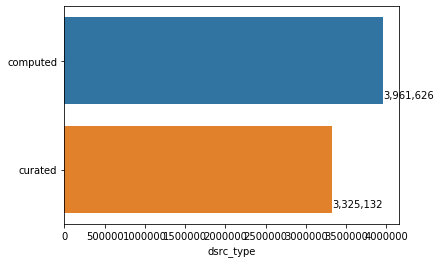

In [156]:
count_plot_h(edges['dsrc_type'])

In [157]:
edges['type'].value_counts()

part_of                 5617702
has_input                668212
has_output               632986
in_taxon                 424605
follows_in_sequence       49821
involved_in               31945
regulates                 25441
positively_regulates       6303
enables                    3662
negatively_regulates       3173
fucntion_altered_in        2373
associated_with            1232
disrupts                    671
disrupted_in                613
Name: type, dtype: int64

In [158]:
combo = combine_nodes_and_edges(nodes, edges)

In [159]:
meta_edges = combo['start_label'] + '_' + combo['type'] + '_' + combo['end_label']
meta_edges.nunique()

58

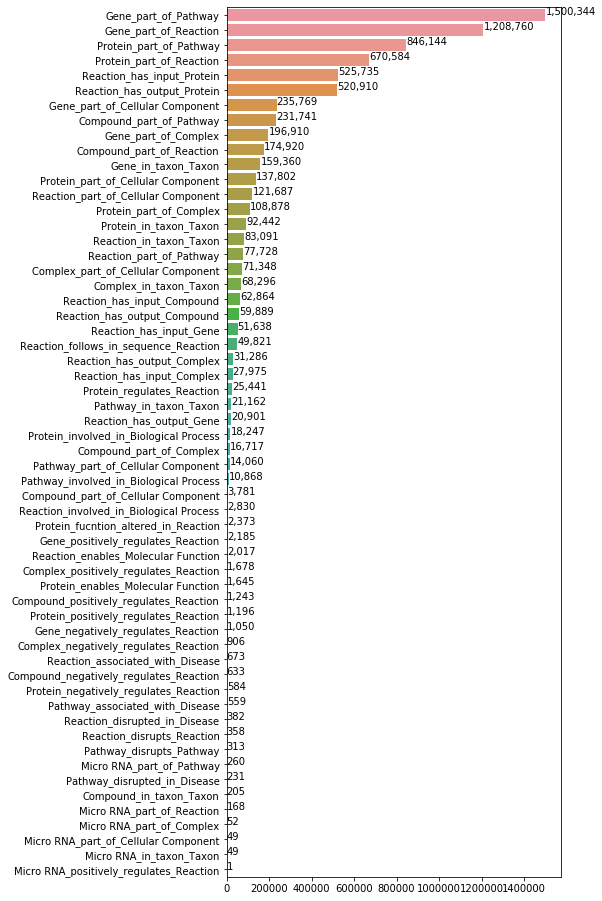

In [160]:
plt.figure(figsize=(6, 16))
count_plot_h(meta_edges)

# Save results

In [161]:
edges['source'] = 'Reactome'
edges['license'] = 'CC0 1.0'

In [162]:
nb_name = '02b_Reactome_Process_Queries'
out_dir = Path('../2_pipeline/').joinpath(nb_name, 'out').resolve()

# Make the output directory if doesn't already exist
out_dir.mkdir(parents=True, exist_ok=True)

nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
edges.to_csv(out_dir.joinpath('edges.csv'), index=False)